# Example parameter inference using synthetic data (in Julia)

##### By James Holehouse: jamesholehouse1@gmail.com

This notebook provides a brief tour of stochastic simulations and parameter inference in stochastic gene expression. It covers usage of the stochastic simulation algorithm (SSA), finite state projection (FSP), maximum likelihood estimation (MLE) and Bayesian parameter inference.

The aim of parameter inference is to fit models to data and in the process recover parameters for our models that best explain the data. Parameter inference can also be used in combination with *information criteria* to determine which model is most appropriate for a given set of experimental data (known as model selection). This notebook will not cover information criteria, but they are relativly easy to use. If you want to know more you can email me (I can provide examples) or else speak to Kaan or Ramon (of the [Grima group](https://grimagroup.bio.ed.ac.uk/group-members)).

## Packages

Before running this notebook make sure you install the following packages using the command below (after uncommenting). If you haven't yet installed the latest version of Julia please do so [here](https://julialang.org/downloads/).

In [1]:
# ] add Plots LaTeXStrings Distributions DoubleFloats Plots.PlotMeasures 
#         Catalyst DiffEqJump FiniteStateProjection OrdinaryDiffEq DifferentialEquations
#             SparseArrays LinearAlgebra Turing BlackBoxOptim Optim

We can then load the packages into the notebook.

In [2]:
# load packages
using Plots, LaTeXStrings, Distributions, DoubleFloats, Plots.PlotMeasures, 
        Catalyst, DiffEqJump, FiniteStateProjection, OrdinaryDiffEq, DifferentialEquations, 
            SparseArrays, LinearAlgebra, BlackBoxOptim, Turing
# theme for plots
Plots.theme(:dao)

Also, please make sure you have downloaded the other files in the GitHub repo and that everything is in the same folder (they contain vital code for the notebook!)

## Creating synthetic data using the SSA 

In this section, we show how to run the SSA to produce synthetic data. We use a manually coded SSA for clarity that utilises the direct SSA method shown in [Gillespie's review](https://www.annualreviews.org/doi/abs/10.1146/annurev.physchem.58.032806.104637). There do exist packages in Julia that allow one to use the SSA without manually coding it up, and you can explore usage of that with respect to *genetic autoregulation* [here](https://github.com/jamesholehouse/SSAandFSPexample/blob/main/Julia_SSA_FSP_example.ipynb).

The example reaction scheme that we will use in this notebook is the telegraph model of gene expression (for context see introduction to [this paper](https://royalsocietypublishing.org/doi/pdf/10.1098/rsif.2021.0510)). The reaction scheme is explicitly given as,
$$ G\xrightarrow{k_{off}}G^\star, G^\star\xrightarrow{k_{on}}G, G\xrightarrow{k_{m}} G+M, M\xrightarrow{k_{d}}\varnothing.$$
In this notebook we make sure to only use steady state data. This can be taken across a population of cells (e.g., smFISH snapshot data) or in a lineage sense (e.g., mother machine data). Verification that the steady state has been reached in the synthetic data can be seen where the moments (and probability distributions) do not change in time.

Let's create some population snapshot and lineage data. We assume that we have access to the mRNA number, but not the gene state since this is difficult to measure in real experiments. First we need to import the SSA package.

In [3]:
path_to_folder = pwd(); file_path = join([path_to_folder,"/SSA-TM.jl"]);
include(file_path);
using .SSATM

And now choose a parameter set corresponding to the synthetic data set.

In [4]:
pars = [0.1,0.3,10.0,0.5]; # in order kon, koff, km, kd

At steady state we have indistinguishability in one of the parameters (i.e., increasing all rate parameters by some scale factor $c$ gives the same probability distribution). Therefore, we define a rescaled parameter set too (rescaled by $k_d$). Make a mental note of this "true" parameter set.

In [5]:
rs_pars = pars./pars[4]

4-element Vector{Float64}:
  0.2
  0.6
 20.0
  1.0

First, let's produce some population data over 2000 cells (make sure to check that steady state has been reached). The arguments of the SSA function correspond to: (1) the number of independent SSA runs (the number of cells), (2) the parameters for the simulation, (3) the total simulation time, and (4) the storage period (time between experimental measurements). We take our population snapshot at the final timepoint for $M$ data across all the cells.

In [6]:
pop_data = SSA(2000, pars, 300, 1.0)[2,:,end];
# print(transpose(pop_data)) # print the mRNA numbers

1000
2000


Second, let's produce some lineage data. Now our data will consist of a single SSA run, but we follow a steady state trajectory over many timepoints. Let's say we have access to 500 individual readings in time.

In [7]:
all_lin_data = SSA(1, pars, 1000, 1.0)
# take 100 timepts of this lineage data.
lin_data = all_lin_data[2,:,end-499:end]
# convert data to a Vector
l_data = vcat(lin_data...);

For clarity, we can plot the lineage data and see how it fluctuates. Before this though make a color blind color scheme.

In [8]:
pal = cgrad(:tol_muted);
chosen_pal = [pal[i] for i in 0.1:0.1:0.7]

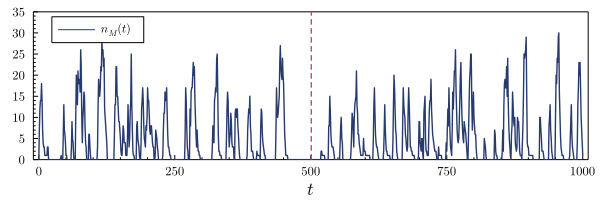

In [9]:
time_pts = collect(0:1.0:1000.0)
plot(time_pts,vcat(all_lin_data[2,:,:]...), label = L"$n_M(t)$", legend = :topleft, 
    bottom_margin = 3PlotMeasures.mm, lc = chosen_pal[3], xlim = (-10,1010), ylim = (0,35))
plot!(grid = false, minorgrid = false, size = (600,200))
plot!([501,501],[0,40], style = :dash, label = :none, lc = chosen_pal[7])
xlabel!(L"t")

The data to the right of the dotted red line above is the steady state lineage data. For the rest of this tutorial we will explicitly do inference with the population data (although very easily one could use the lineage data). 

## Numerical analytics using the FSP for fast evaluation 

When using Julia it can be quite tricky to use exact solutions for probability distributions that have a complicated functional form (for this Mathematica is ideal). For example, the solution to the telegraph model comes in the form of a hypergeometric function (see SI protocol of [this](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.0040309#s5)). It can thus be easier to utilise compuational methods to solve a truncated state space version of this system. One can either refer to the orignal FSP papers [here](https://aip.scitation.org/doi/full/10.1063/1.2145882) and [here](https://aip.scitation.org/doi/full/10.1063/1.5006484) or else look at the associated section in the following [PhD thesis](https://github.com/jamesholehouse/jamesholehouse.github.io/blob/gh-pages/assets/papers/PhD_Thesis-2.pdf) to understand the time-dependent FSP and its steady state modified version. In this notebook we utilise the steady state FSP as shown in the PhD thesis.

In short, the FSP provides a way to evaluate the chemical master equation under a finite state approximation of an infinite state space problem. In our system, $M$ is an unbounded species, meaning that there is a finite probability $P(n_M)$ of having any value of $n_M\in [0,1,2,\dots,\infty)$. For our example above, we use a state space truncation of $N=100$, since $P(N)$ is then a very small probability for the parameters in `pars`.

In this tutorial we have manually coded up an FSP for clarity, however, one can easily do this for any reaction scheme using methods from [`FiniteStateProjection.jl`](https://github.com/kaandocal/FiniteStateProjection.jl) (see [here](https://github.com/jamesholehouse/SSAandFSPexample/blob/main/Julia_SSA_FSP_example.ipynb) for an example applied to genetic autoregulation).

First, let's import the FSP package from our filepath.

In [10]:
file_path2 = join([path_to_folder,"/FSP-TM.jl"]);
include(file_path2);
using .FSPTM

One can then use the FSP to output a probability distribution of interest.

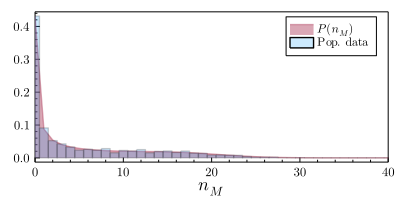

In [11]:
# set state space truncation.
N = 100;
# create the FSP distribution for the true pars and the state space truncation N
Pn_true = FSP(pars, N);
# plot the distribution
plot(0:N,Pn_true, label = L"P(n_M)", legend = :topright, lc = chosen_pal[7], 
    fill = true, c = chosen_pal[7], alpha=0.5, xlim = (0,40))
histogram!(pop_data, bins = collect(-0.5:1.0:N+0.5), norm = true, alpha = 0.2, label = L"\mathrm{Pop.\;data}")
plot!(grid = false, minorgrid = false, size = (400,200))
xlabel!(L"n_M")

We can also make a quick sanity check that the probability sums to 1.

In [12]:
sum(Pn_true)

1.0

Which it does! Finally, given some population data one can calculate the negative log-likelhood of observing a given steady state trajectory given the underlying probability distribution. Using the lineage data above and our FSP this gives...

In [13]:
true_min_llh = -sum([log10(Pn_true[floor(Int,x+1)]) for x in pop_data])

2080.913466006199

We will comment on why we do this below, just keep this number in mind.

## Maximum likelihood estimation (using Optim.jl and BlackBoxOptim.jl)

### What is maximum likelihood estimation (MLE)?

Maximum likehood estimation is the process of identifying a set of parameters in a model that maximises the likelihood of the observed data. For our example, for each observation in `pop_data` we can calculate the likelihood as the product of the probabilities of each observation, i.e., $\mathcal{L} = \prod_{i\in \rm{pop\;data}} P(i)$ (events assumed independent therefore the probability of seeing all events together is simply the product). Say we don't know the optimal parameters $\theta_{\mathrm{max}} = (k_{on},k_{off},k_m,k_d)$, but that for any set $\theta$ we can calucate $P(n_M|\theta)$. The likelihood of observing the data for some parameter set $\theta$ is then $\mathcal{L}(\theta) = \prod_{i\in l_{\mathrm{data}}} P(i|\theta)$. By maximising this likelihood one can then determine the parameters of the model that best describe the data.

In practise $\mathcal{L}(\theta)$ is very small, therefore it is more computationally viable to minimise the negative logarithm of $\mathcal{L}(\theta)$.

### Specifying a cost function

We now need a function that will calculate the negative logarithm of the likelihood of the data given a set of parameters. Note that the optimisation itself will be done in log-space, hence the `log10`'s and `10 .^`'s below.

Due to the indistinguishability at steady state, we will set $k_d=1$ and infer the other three remaining parameters. One can then compare the results of the inference to `rs_pars`.

In [14]:
# θ is a three-element vector
function negllh(θ)
    # kd fixed at 1
    FSPprob = FSP(vcat(10 .^θ, 1.0), N)
    # abs for the few cases where FSP returns negative prob
    return -sum([log10(abs(FSPprob[floor(Int,x+1)])) for x in pop_data])
end

negllh (generic function with 1 method)

As a test let's use some random parameter set.

In [15]:
negllh(log10.([0.001,2.0,4.0]))

7787.685610324399

As expected this gives a much larger NLL than the true parameters.

### Optimising the cost function

We can now use optimisation algorithms to provide a *point estimate* of the set of parameters that best describe the data. There are two possible options here: local optimisation and global optimisation. Local optimisation, although not guaranteed to find a global minimum in a "finite" time, will generally find a very good local minimum in a short amount of time. On the other hand, global optimisation is guaranteed to find the global minimum in a "finite" time, but this can take a very long time and often it takes a great deal of time to find a minmum as good as local optimisation. In this notebook we will show how to use both and compare the results!

#### Local optimisation

Starting with the local optimisation, we use the package `Optim.jl` and specifically the Nelder-Mead algorithm.

In [16]:
using Optim

The choice of starting point is very important in local optimisation. Start in at the wrong point in parameter space and a bad local optima may be chosen. With no information start with something uniform, say $\theta_{\mathrm{init}} = (1,1,1).$

In [17]:
nmopt = Optim.optimize(negllh, log10.([1.0,1,1]))

 * Status: success

 * Candidate solution
    Final objective value:     2.079849e+03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    142
    f(x) calls:    254


In [18]:
nm_par = 10 .^Optim.minimizer(nmopt)

3-element Vector{Float64}:
  0.195385240991848
  0.5551813198668756
 18.892872114467576

Compare to `rs_pars`.

In [19]:
rs_pars

4-element Vector{Float64}:
  0.2
  0.6
 20.0
  1.0

Plot the inferred parameter distribution against the true distribution.

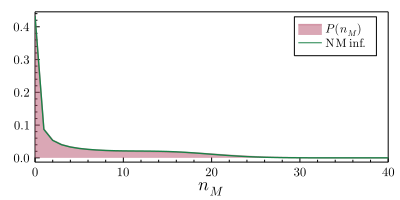

In [20]:
plot(0:N,Pn_true, label = L"P(n_M)", legend = :topright, lc = chosen_pal[7], 
    fill = true, c = chosen_pal[7], alpha=0.5, xlim = (0,40))
plot!(0:N,FSP(vcat(nm_par,1),N), lc = chosen_pal[2], label = L"\mathrm{NM\; inf.}")
plot!(grid = false, minorgrid = false, size = (400,200))
xlabel!(L"n_M")

Okay, so pretty good inference. However, the initial condition we chosen was quite close to the true parameter set and one does not know a good initial condition *a priori*. Global optimisation does not require such a specification of initial condition.

#### Global optimisation

Now let's try some global optimisation. Unlike local optimisation one does not need to guess an initial parameter set, rather we need to specify some bounds on the search range (`SRange`). Often one can make a good guess on the bounds of the search range based on (experiment specific) timescale separation arguments. Given little information it's generally best to choose these over several orders of magnitude so that any necessary timescale separation can occur. Specifically, we use the adaptive differential evolution algorithm below. To increase the inference accuracy, increase the number of steps in `MaxSteps` below.

In [21]:
using BlackBoxOptim

In [22]:
# specify the search range in log-space
SRange=[(-2.0,2.0), (-2.0,2.0), (-2.0,2.0)]
# run the optimiser
res = bboptimize(negllh; Method = :adaptive_de_rand_1_bin_radiuslimited, 
                    SearchRange = SRange, NumDimensions = 3, PopulationSize = 1000000, 
                    MaxSteps = 2000) # , TraceMode=:silent
# collec the log10 pars
opt_pars = best_candidate(res)
# exponentiate for the real space pars
fit_pars = 10 .^(opt_pars)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.51 secs, 16 evals, 8 steps, improv/step: 0.625 (last = 0.6250), fitness=2435.385913851
1.02 secs, 88 evals, 44 steps, improv/step: 0.500 (last = 0.4722), fitness=2197.061326241
1.54 secs, 156 evals, 78 steps, improv/step: 0.487 (last = 0.4706), fitness=2197.061326241
2.05 secs, 228 evals, 114 steps, improv/step: 0.456 (last = 0.3889), fitness=2144.344448510
2.56 secs, 282 evals, 141 steps, improv/step: 0.482 (last = 0.5926), fitness=2144.344448510
3.06 secs, 358 evals, 179 steps, improv/step: 0.469 (last = 0.4211), fitness=2144.344448510
3.59 secs, 382 evals, 191 steps, improv/step: 0.476 (last = 0.5833), fitness=2144.344448510
4.09 secs, 458 evals, 229 steps, improv/step: 0.472 (last = 0.4474), fitness=2137.664456795
4.62 secs, 534 evals, 267 steps, improv/step: 0.464 (last = 0.4211

3-element Vector{Float64}:
  0.13891323938196878
  0.4289510315853435
 17.703746490140563

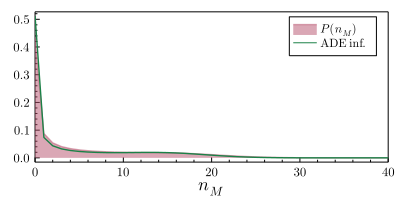

In [23]:
plot(0:N,Pn_true, label = L"P(n_M)", legend = :topright, lc = chosen_pal[7], 
    fill = true, c = chosen_pal[7], alpha=0.5, xlim = (0,40))
plot!(0:N,FSP(vcat(fit_pars,1),N), lc = chosen_pal[2], label = L"\mathrm{ADE\; inf.}")
plot!(grid = false, minorgrid = false, size = (400,200))
xlabel!(L"n_M")

So clearly, this inference takes a lot longer, and since the algorithm is not determinstic it often returns varied inference results. Depending on the optimisation conducted one can get good or bad inference of the model parameters and the associated probability distribution.

#### Local optimisation using initial condition from global optimation

We can bypass the problems with local and global optimisation by combining the two. Specifically the problems are: local optimisation is highly initial condition dependent, whereas global optimisation is very time consuming and often does not converge locally. One can use global optimisation to find an initial condition for the local optimisation procedure. This way, the local optimisation finds the local optimum of a parameter set likely to be in the vicinity of the global optimum.

In [24]:
# run the NM alg with IC from global opt
nmopt_goodIC = Optim.optimize(negllh, opt_pars)

 * Status: success

 * Candidate solution
    Final objective value:     2.079849e+03

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    84
    f(x) calls:    161


In [25]:
nm_par_goodIC = 10 .^Optim.minimizer(nmopt_goodIC)

3-element Vector{Float64}:
  0.19538718122223148
  0.5551900998614937
 18.892892480825125

In [26]:
rs_pars

4-element Vector{Float64}:
  0.2
  0.6
 20.0
  1.0

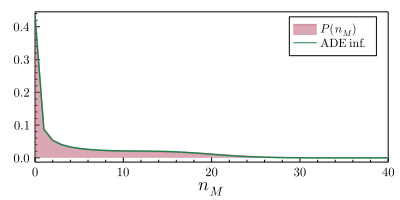

In [27]:
plot(0:N,Pn_true, label = L"P(n_M)", legend = :topright, lc = chosen_pal[7], 
    fill = true, c = chosen_pal[7], alpha=0.5, xlim = (0,40))
plot!(0:N,FSP(vcat(nm_par_goodIC,1),N), lc = chosen_pal[2], label = L"\mathrm{ADE\; inf.}")
plot!(grid = false, minorgrid = false, size = (400,200))
xlabel!(L"n_M")

Clearly, the rescaled parameter set and the probability distribution is well-recovered by this procedure.

### Common Issues with MLE

The most common issues with maximum likelihood inference of this type are:
* 1. If there is not enough experimental data the distribution of the data many not match the "true" underlying distribution (for a same parameter set) leading to skewed inference results.
* 2. Different regions of parameter space often correspond to very similar probability distributions meaning that the "true" parameters cannot be successfully inferred. This problem is related to so-called *parameter indistinguishability*. 
* 3. MLE only provides a point estimate with no measure of uncertainty on the predictions. This can be bypassed with Bayesian inference introduced below.

## Bayesian inference via Metropolis Hastings algorithm (using Turing.jl)

Bayesian inference is different to MLE: while MLE gives a single point parameter estimate, Bayesian inference relies on Bayes' theorem to sample the areas of the parameter space associated with the maximum likelihood point. In practise, one often uses algorithms that do not require explicit evaluation of the Bayesian evidence (since this is computationally costly) via algorithms such as Metropolis-Hasting's (MH), Gibbs sampling or Hamiltonian Monte Carlo. In what follows we use the MH algorithm, which although considered one of the more basic algorithms is perfect for our usage. The downsides of the MH algorithm are that often convergence to the area of parameter space associated with the maximum likelihood is slow, but this can be alleviated by use of adaptive algorithms (where larger steps are taken in parameter space with low likelihood) or else by choosing an initial parameter set that is in the maximum likelihood region.

There are several choices to be made in performing Bayesian inference. The first is what algorithm to choose. The second is the prior distributions one chooses over parameter space. When little is known about a problem it is often wise to use a uniform prior distribution over an area of parameter space that seems biologically relevant. Another often-used prior is the log-uniform prior which is useful when the time scales of the parameters could vary over several orders of magnitude (plotting the log-uniform distribution with a logarithm x-axis gives a distribution that appear uniform). The final choice is the proposal distribution which determines, given a point in parameter space, the probability of the next point in parameter space. Proposal distributions can be fixed (independent of the point currently sampled) or else they can be relative to the point currently sampled (like a random walk).

In this notebook we using `Turing.jl` to conduct a MH algorithm with log-uniform priors and a proposal distribution that follows a random walk like motion through parameter space. Let's load the relevant packages.

In [28]:
using MCMCChains, Distributions, StatsPlots, Turing, AdvancedMH

The following files converts our FSP distributions to `Distribution` structs for usage in `Turing.jl`.

In [29]:
file_path3 = join([path_to_folder,"/FSP-distributions.jl"]);
include(file_path3)

### Using the MLE as the initial condition

To ensure that our initial point in parameter space is in the region associated with maximum likelihood one can use the MLE previous found as the initial condition.

Let's create the `model` for use in our MH algorithm using `Turing`'s `@model` macro.

In [30]:
@model function ParInf(data)
    # the prior distributions: log-uniform over several order of magnitude
    kon ~ LogUniform(0.01,100.0)
    koff ~ LogUniform(0.01,100.0)
    km ~ LogUniform(0.01,100.0)
    
    # the sampled param vector, including the normalised kd=1
    sampled_pars = [kon, koff, km, 1]
    
    # data values are drawn from a FSP distribution
    FSPdist = FSPd(FSP(sampled_pars,N)) # conveert to a Distribution
    
    # each data point is drawn from the same distribution
    for i in 1:length(data)
        data[i] ~ FSPdist
    end
    
    flush(stdout) # clear the output channel
    return nothing
end;

Now we can set the initial condition for the MH Markov chain through parameter space.

In [31]:
model = ParInf(pop_data);
varinfo = Turing.VarInfo(model);
model(varinfo, Turing.SampleFromPrior(), 
    Turing.PriorContext((kon = nm_par_goodIC[1], koff = nm_par_goodIC[2], km = nm_par_goodIC[3])));
init_theta = varinfo[Turing.SampleFromPrior()]

3-element Vector{Float64}:
  0.19538718122223148
  0.5551900998614937
 18.892892480825125

In addition to the prior distributions, we also need to specify the proposal distributions that dictate how the next sampled parameter set is chosen. Here we choose a random walk proposal distribution (meaning that the distribution for the next sample is centred at the current sample) and choose it to be a multi-variate Gaussian over the three parameters of interest.

Note that generally the width of the multivariate Gaussian in each dimension (`w` below) is generally chosen such that the acceptance probability for each proposed parameter set is $\sim 20\%$. The value of `w=0.004` chosen here was refined over short chains (`iterations=1000`). For the inference below we choose the number of iterations of our MH algorithm to be 10000. In general, one may want to choose this much larger (and wait hours for nice well-defined peaks in the posteriors), however for our purposes this works just fine.

In [32]:
w = 0.004;
iterations = 10000;

flush(stdout)
chain1 = sample(model, 
    MH(RandomWalkProposal(
            MvNormal(zeros(3),
            [w 0 0;
             0 w 0;
             0 0 w;]))
        ),  
iterations, init_params = init_theta, save_state=false, progress=true);

Sampling: 100%|█████████████████████████████████████████| Time: 0:01:10


We see that the acceptance rate is around $0.2$ as we wanted.

In [33]:
acceptance_rate1 = length(unique(chain1[:kon]))/iterations

0.2045

Now, let's plot the posteriors and the accompanying trajectories through parameter space.

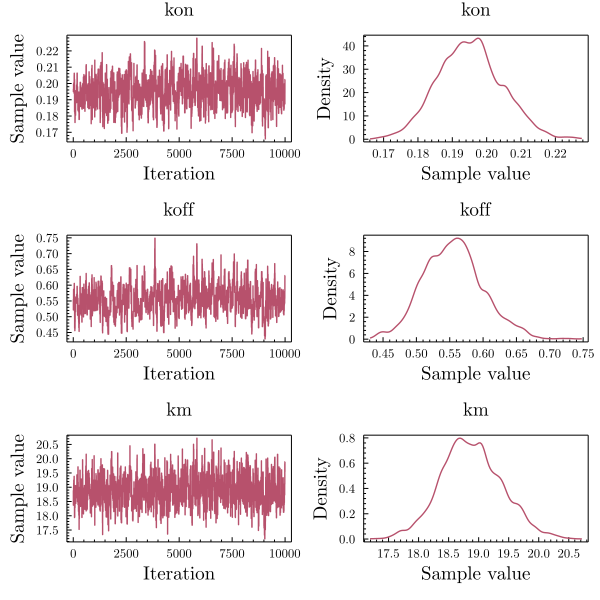

In [34]:
p_summary1 = chain1[1:end]
tp = plot(p_summary1, size=(600,600),
    grid = false, minorgrid = false, lc = chosen_pal[7])#, seriestype = :histogram

The posteriors are unimodal (if you are not properly convinced then run the inference again for `iterations = 1000000`!) and the trajectories through parameter space show no initial transient (aka a "burn in"). This means that from the initial condition of the inference we were already probing the global optimum.

### Starting at a different initial condition: do we still get convergence?

We have seen that the Bayesian inference given a MLE initial condition can lead to nice well defined posteriors centred around the true parameters. Now, generally for convergence to be asserted one must arrive at the same result by using a different set of initial conditions (below for $k_{\mathrm{on}} = k_{\mathrm{off}}=10$ and $k_m = 1.0$). We show that the posteriors are independent of the initial condition in what follows.

First we change the initial condition.

In [35]:
model(varinfo, Turing.SampleFromPrior(), Turing.PriorContext((kon = 10.0, koff = 10.0, km = 1.0)));
init_theta = varinfo[Turing.SampleFromPrior()]

3-element Vector{Float64}:
 10.0
 10.0
  1.0

And then we can run the inference again.

In [36]:
flush(stdout)
chain2 = sample(model, MH(
        RandomWalkProposal(
            MvNormal(zeros(3),
            [w 0 0;
             0 w 0;
             0 0 w;]))
        ),  
iterations, init_params = init_theta, save_state=false, progress=true);

Sampling: 100%|█████████████████████████████████████████| Time: 0:01:24


Again the acceptance rate checks out.

In [37]:
acceptance_rate2 = length(unique(chain2[:kon]))/iterations

0.2001

Plot the results with the burn in still present...

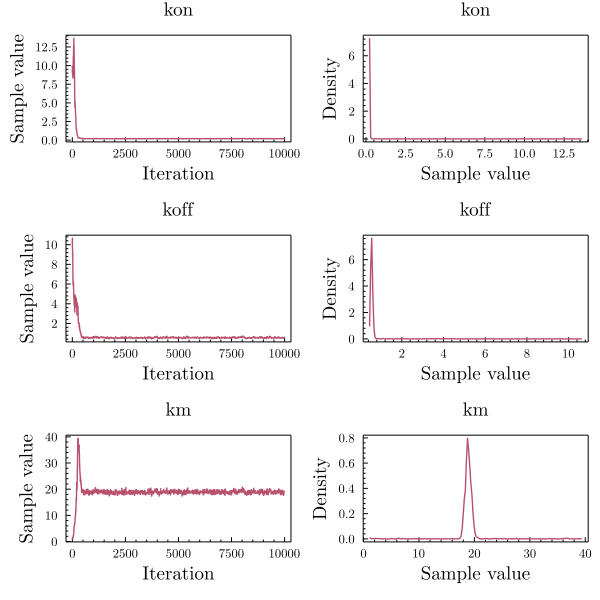

In [38]:
p_summary2 = chain2[1:end]
tp = plot(p_summary2, size=(600,600),
    grid = false, minorgrid = false, lc = chosen_pal[7])

Below we remove the "burn in" (i.e., the initial transient towards the correct values seen in the left-hand plots) and we get the posteriors below which are essentially the same as the posteriors from the initial condition given by result from MLE. Since the posteriors are independent of the initial condition, we know that the inference has successfully converged on the global minimum.

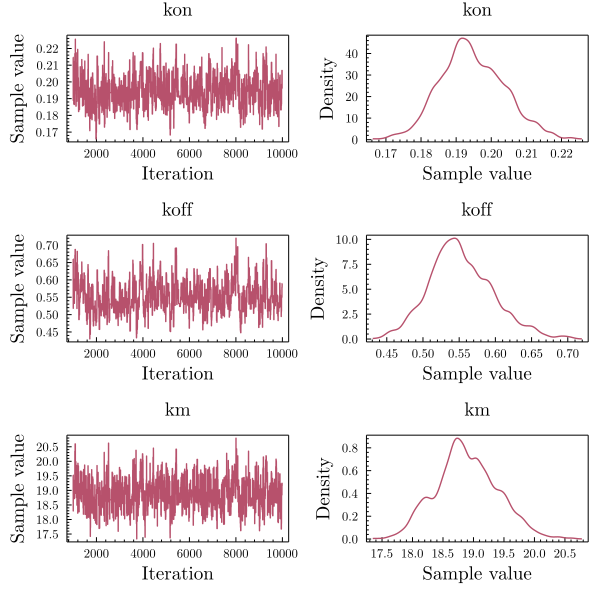

In [39]:
p_summary3 = chain2[1000:end]
tp3 = plot(p_summary3, size=(600,600), 
    grid = false, minorgrid = false, lc = chosen_pal[7])

### Common issues with Bayesian inference

There are several common issues encountered in Bayesian inference (issues you are almost certain to run into!):
* 1. Non-adaptive MCMC algorithms, such as implemented above, can get trapped in areas of parameter space associated with low-likelihood, meaning that convergence is only reached after many many iterations. To get around this you could use different MCMC algorithms that correct for this such as no-u-turn samplers or adaptive MH.
* 2. Bimodal posteriors. If one encounters these and is *sure* that the algorithm has converged and that any "burn in" has been removed, then there is little choice other than to report the bimodality in the likelihood function. Bimodal posteriors meaning that several parameter sets exist that are likelihood maximising (although one maxima is likely to have a greater likelihood than the other). Bimodal posteriors also highlight a benefit in Bayesian inference compared to MLE, since MLE will only return one of these two maxima.
* 3. Non-convergence. If it seems that your MCMC is not converging this likely means you need to run longer Markov chains. Make sure to check that independent runs from the same starting point return the same posteriors and then check for different initial conditions. Don't be afraid to leave the MCMC chains running for hours (or days!)
* 4. Some parameters have converged posteriors, while others have not. In this case you may want to increase the width of the proposal distributions used on the non-converged parameters. This means you are much more likely to return a monomodal posterior since jumps are not so small as to keep choosing parameters over a small region of parameter space.

## Additional Tasks

* 1. Try performing the inference above using less cells (say 500). What issues are encountered when you do this?
* 2. Perform the inference above for the lineage data. How many timepoints are required to get as good inference as the population data inference above for 2000 cells?
* 3. Try conducting the inference above for a new parameter set (e.g., `kon = 10, koff = 1, km = 10, kd = 1`). What issues are now encountered in the inference?

This completes your first inference of synthetic gene expression data using the SSA, FSP, MLE and MH MCMC Bayesian inference! Yay! If you've any feedback on this tutorial please email me. Otherwise, I hope you have enjoyable inference!

Thanks to Zhixing Cao, Kaan Ocal and Ramon Grima for being very good teachers in learning parameter inference.